# Analysis Notebook for Template Technology

In [1]:
import os
import sys

import numpy             as np
import matplotlib.pyplot as pl
import pandas            as pd
import seaborn           as sb

sys.path.insert(0, os.path.abspath("../../../src"))

import tyche             as ty

## Load data

In [2]:
designs = ty.Designs(path = '.',
                     name = 'template.xlsx')
investments = ty.Investments(path = '.',
                             name = 'template.xlsx')

### Compile the production and metric functions for each technology in the dataset.

In [3]:
designs.compile()

## Evaluate the scenarios in the dataset.

In [4]:
scenario_results = designs.evaluate_scenarios(sample_count=10)

Evaluating Technology A
Evaluating Technology M


In [5]:
scenario_results.xs(1, level="Sample", drop_level=False)

Value  \
Technology   Scenario                     Sample Variable Index                               
Technology A All Components Fast Progress 1      Cost     Cost                629857.604218   
                                                 Metric   Environment             17.597875   
                                                          Labor                    3.048032   
                                                          Overall Efficiency       0.369879   
                                                          System Cost          88502.074934   
...                                                                                     ...   
Technology M Peripherals Slow Progress    1      Metric   Overall Efficiency       0.438123   
                                                          System Cost          63508.157355   
                                                 Output   Output F                27.163654   
                                                          Output G                 9.612787   
                                                          Output P                14.978792   

                                                                                                     Units  
Technology   Scenario                     Sample Variable Index                                             
Technology A All Components Fast Progress 1      Cost     Cost                                  USD/system  
                                                 Metric   Environment                    delta unit/system  
                                                          Labor                           delta USD/system  
                                                          Overall Efficiency                      unitless  
                                                          System Cost         delta USD/system, annualized  
...                                                                                                    ...  
Technology M Peripherals Slow Progress    1      Metric   Overall Efficiency                      unitless  
                                                          System Cost         delta USD/system, annualized  
                                                 Output   Output F                               mass/year  
                                                          Output G                               mass/year  
                                                          Output P                               mass/year  

[160 rows x 2 columns]

[Text(0, 0, 'Current State'),
 Text(1, 0, 'All Components Slow Progress'),
 Text(2, 0, 'All Components Moderate Progress'),
 Text(3, 0, 'All Components Fast Progress'),
 Text(4, 0, 'Efficiency Slow Progress'),
 Text(5, 0, 'Efficiency Moderate Progress'),
 Text(6, 0, 'Efficiency Fast Progress'),
 Text(7, 0, 'Peripherals Slow Progress'),
 Text(8, 0, 'Peripherals Moderate Progress'),
 Text(9, 0, 'Peripherals Fast Progress')]

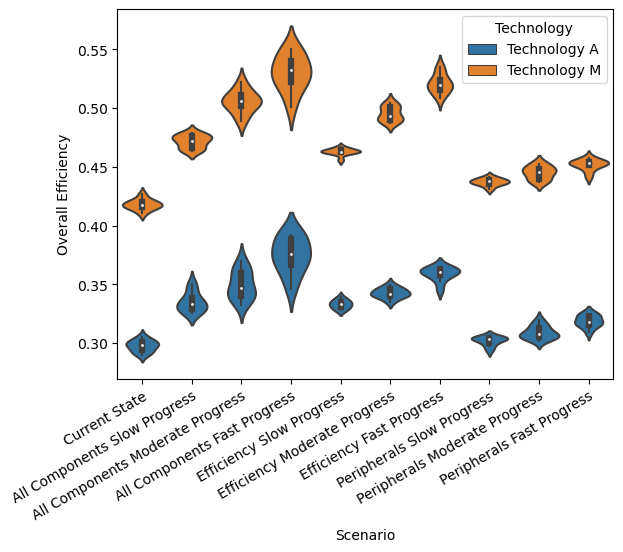

In [6]:
g = sb.violinplot(
    x="Scenario",
    y="Value",
    hue="Technology",
    data=scenario_results.xs(
        ("Metric", "Overall Efficiency"),
        level=["Variable", "Index"]
    ).reset_index()[["Technology", "Scenario", "Value"]],
    dodge=False,
    order=[
        "Current State"              ,
        "All Components Slow Progress"      ,
        "All Components Moderate Progress"  ,
        "All Components Fast Progress"      ,
        "Efficiency Slow Progress"    ,
        "Efficiency Moderate Progress",
        "Efficiency Fast Progress"    ,
        "Peripherals Slow Progress"         ,
        "Peripherals Moderate Progress"     ,
        "Peripherals Fast Progress"         ,
    ]
)
g.set(ylabel="Overall Efficiency")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')

[Text(0, 0, 'Current State'),
 Text(1, 0, 'All Components Slow Progress'),
 Text(2, 0, 'All Components Moderate Progress'),
 Text(3, 0, 'All Components Fast Progress'),
 Text(4, 0, 'Efficiency Slow Progress'),
 Text(5, 0, 'Efficiency Moderate Progress'),
 Text(6, 0, 'Efficiency Fast Progress'),
 Text(7, 0, 'Peripherals Slow Progress'),
 Text(8, 0, 'Peripherals Moderate Progress'),
 Text(9, 0, 'Peripherals Fast Progress')]

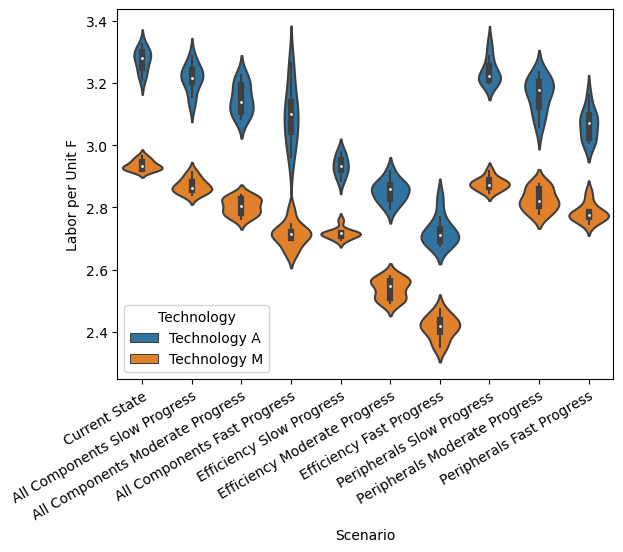

In [7]:
g = sb.violinplot(
    x="Scenario",
    y="Value",
    hue="Technology",
    data=scenario_results.xs(
        ("Metric", "Labor"),
        level=["Variable", "Index"]
    ).reset_index()[["Technology", "Scenario", "Value"]],
    dodge=False,
    order=[
        "Current State"              ,
        "All Components Slow Progress"      ,
        "All Components Moderate Progress"  ,
        "All Components Fast Progress"      ,
        "Efficiency Slow Progress"    ,
        "Efficiency Moderate Progress",
        "Efficiency Fast Progress"    ,
        "Peripherals Slow Progress"         ,
        "Peripherals Moderate Progress"     ,
        "Peripherals Fast Progress"         ,
    ]
)
g.set(ylabel="Labor per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')

[Text(0, 0, 'Current State'),
 Text(1, 0, 'All Components Slow Progress'),
 Text(2, 0, 'All Components Moderate Progress'),
 Text(3, 0, 'All Components Fast Progress'),
 Text(4, 0, 'Efficiency Slow Progress'),
 Text(5, 0, 'Efficiency Moderate Progress'),
 Text(6, 0, 'Efficiency Fast Progress'),
 Text(7, 0, 'Peripherals Slow Progress'),
 Text(8, 0, 'Peripherals Moderate Progress'),
 Text(9, 0, 'Peripherals Fast Progress')]

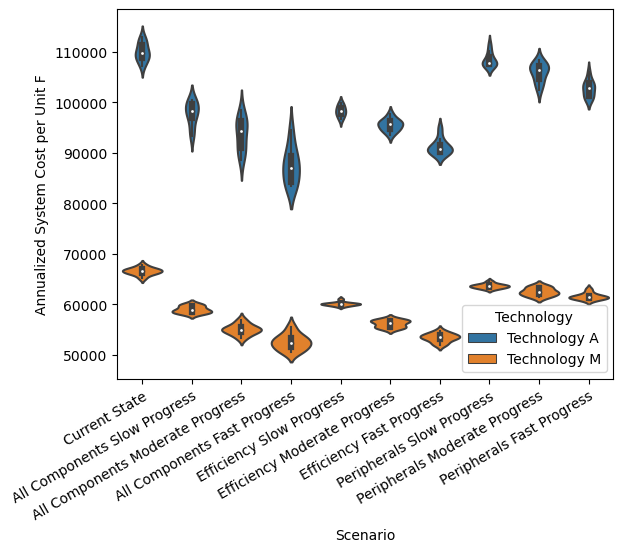

In [8]:
g = sb.violinplot(
    x="Scenario",
    y="Value",
    hue="Technology",
    data=scenario_results.xs(
        ("Metric", "System Cost"),
        level=["Variable", "Index"]
    ).reset_index()[["Technology", "Scenario", "Value"]],
    dodge=False,
    order=[
        "Current State"              ,
        "All Components Slow Progress"      ,
        "All Components Moderate Progress"  ,
        "All Components Fast Progress"      ,
        "Efficiency Slow Progress"    ,
        "Efficiency Moderate Progress",
        "Efficiency Fast Progress"    ,
        "Peripherals Slow Progress"         ,
        "Peripherals Moderate Progress"     ,
        "Peripherals Fast Progress"         ,
    ]
)
g.set(ylabel="Annualized System Cost per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')

[Text(0, 0, 'Current State'),
 Text(1, 0, 'All Components Slow Progress'),
 Text(2, 0, 'All Components Moderate Progress'),
 Text(3, 0, 'All Components Fast Progress'),
 Text(4, 0, 'Efficiency Slow Progress'),
 Text(5, 0, 'Efficiency Moderate Progress'),
 Text(6, 0, 'Efficiency Fast Progress'),
 Text(7, 0, 'Peripherals Slow Progress'),
 Text(8, 0, 'Peripherals Moderate Progress'),
 Text(9, 0, 'Peripherals Fast Progress')]

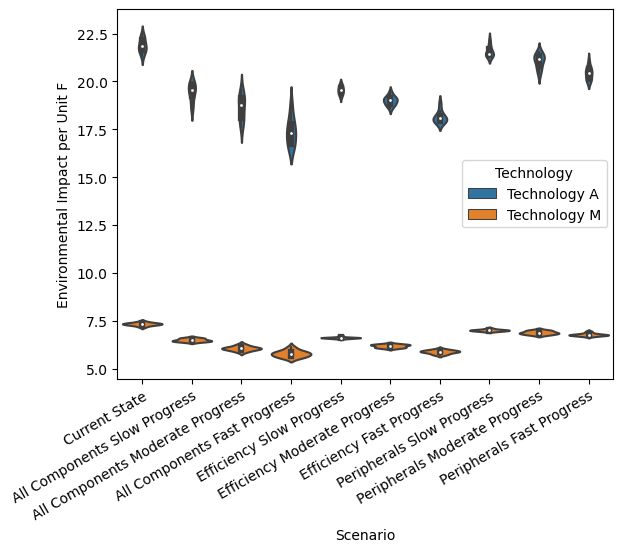

In [9]:
g = sb.violinplot(
    x="Scenario",
    y="Value",
    hue="Technology",
    data=scenario_results.xs(
        ("Metric", "Environment"),
        level=["Variable", "Index"]
    ).reset_index()[["Technology", "Scenario", "Value"]],
    dodge=False,
    order=[
        "Current State"              ,
        "All Components Slow Progress"      ,
        "All Components Moderate Progress"  ,
        "All Components Fast Progress"      ,
        "Efficiency Slow Progress"    ,
        "Efficiency Moderate Progress",
        "Efficiency Fast Progress"    ,
        "Peripherals Slow Progress"         ,
        "Peripherals Moderate Progress"     ,
        "Peripherals Fast Progress"         ,
    ]
)
g.set(ylabel="Environmental Impact per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor')

## Evaluate the investments in the dataset.

In [10]:
investment_results = investments.evaluate_investments(designs, sample_count=100)

Evaluating Technology A
Evaluating Technology M
Evaluating Technology A
Evaluating Technology M


### Costs of investments - these calculations are not set up correctly

In [11]:
investment_results.amounts

,Amount
Investment,
"High Budget, All Categories",20250000.0
"High Budget, Components Only",15500000.0
"Low Budget, All Categories",9250000.0
"Low Budget, Components Only",6500000.0
"Medium Budget, All Categories",12250000.0
"Medium Budget, Components Only",8500000.0


### Benefits of investments.

In [12]:
investment_results.metrics.xs(1, level="Sample", drop_level=False)

Value  \
Investment                  Category                 Tranche                   Scenario                     Sample Technology   Index                               
High Budget, All Categories Research on Component B0 Component B0 High Funding All Components Fast Progress 1      Technology A Environment             18.745425   
                                                                                                                                Labor                    3.189898   
                                                                                                                                Overall Efficiency       0.347236   
                                                                                                                                System Cost          94273.254970   
                                                                                                                   Technology M Environment              5.578304   
...                                                                                                                                                           ...   
Low Budget, All Categories  Research on Peripherals  Peripherals Low Funding   Peripherals Slow Progress    1      Technology A System Cost         107542.645994   
                                                                                                                   Technology M Environment              6.989827   
                                                                                                                                Labor                    2.868073   
                                                                                                                                Overall Efficiency       0.438425   
                                                                                                                                System Cost          63464.451791   

                                                                                                                                                                           Units  
Investment                  Category                 Tranche                   Scenario                     Sample Technology   Index                                             
High Budget, All Categories Research on Component B0 Component B0 High Funding All Components Fast Progress 1      Technology A Environment                    delta unit/system  
                                                                                                                                Labor                           delta USD/system  
                                                                                                                                Overall Efficiency                      unitless  
                                                                                                                                System Cost         delta USD/system, annualized  
                                                                                                                   Technology M Environment                    delta unit/system  
...                                                                                                                                                                          ...  
Low Budget, All Categories  Research on Peripherals  Peripherals Low Funding   Peripherals Slow Progress    1      Technology A System Cost         delta USD/system, annualized  
                                                                                                                   Technology M Environment                    delta unit/system  
                                                                                                                                Labor                           delta USD/system  
                                         

In [13]:
investment_results.summary.xs(1, level="Sample", drop_level=False)

Value  \
Investment                     Technology   Sample Index                               
High Budget, All Categories    Technology A 1      Environment            133.149680   
                                                   Labor                   21.868261   
                                                   Overall Efficiency       2.398833   
                                                   System Cost         669627.594862   
                               Technology M 1      Environment             40.400249   
                                                   Labor                   18.691173   
                                                   Overall Efficiency       3.730792   
                                                   System Cost         366815.891913   
High Budget, Components Only   Technology A 1      Environment            137.477692   
                                                   Labor                   22.436669   
                                                   Overall Efficiency       2.331290   
                                                   System Cost         691393.747048   
                               Technology M 1      Environment             42.292455   
                                                   Labor                   19.392549   
                                                   Overall Efficiency       3.598016   
                                                   System Cost         383996.260268   
Low Budget, All Categories     Technology A 1      Environment            136.302708   
                                                   Labor                   22.323582   
                                                   Overall Efficiency       2.343718   
                                                   System Cost         685484.594698   
                               Technology M 1      Environment             45.998212   
                                                   Labor                   20.068315   
                                                   Overall Efficiency       3.266873   
                                                   System Cost         417642.846763   
Low Budget, Components Only    Technology A 1      Environment            139.030334   
                                                   Labor                   22.651712   
                                                   Overall Efficiency       2.302998   
                                                   System Cost         699202.191594   
                               Technology M 1      Environment             46.764047   
                                                   Labor                   20.307518   
                                                   Overall Efficiency       3.218490   
                                                   System Cost         424596.278493   
Medium Budget, All Categories  Technology A 1      Environment            134.757278   
                                                   Labor                   22.172321   
                                                   Overall Efficiency       2.372103   
                                                   System Cost         677712.417466   
                               Technology M 1      Environment             43.773081   
                                                   Labor                   19.557738   
                                                   Overall Efficiency       3.437014   
                                                   System Cost         397439.670213   
Medium Budget, Components Only Technology A 1      Environment            137.813024   
                                                   Labor                   22.549714   
                                                   Overall Efficiency       2.325101   
                                                   System Cost         693080.176050   
                               

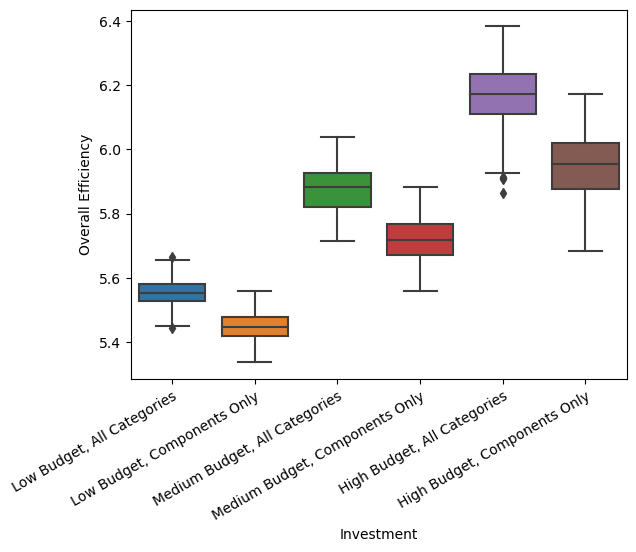

In [14]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "Overall Efficiency",
        level="Index"
    ).groupby(["Investment", "Sample"]).sum(numeric_only=True).reset_index()[["Investment", "Value"]],
    order=[
        "Low Budget, All Categories"      ,
        "Low Budget, Components Only"  ,
        "Medium Budget, All Categories"      ,
        "Medium Budget, Components Only"    ,
        "High Budget, All Categories",
        "High Budget, Components Only"
    ]
)
g.set(ylabel="Overall Efficiency")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor');

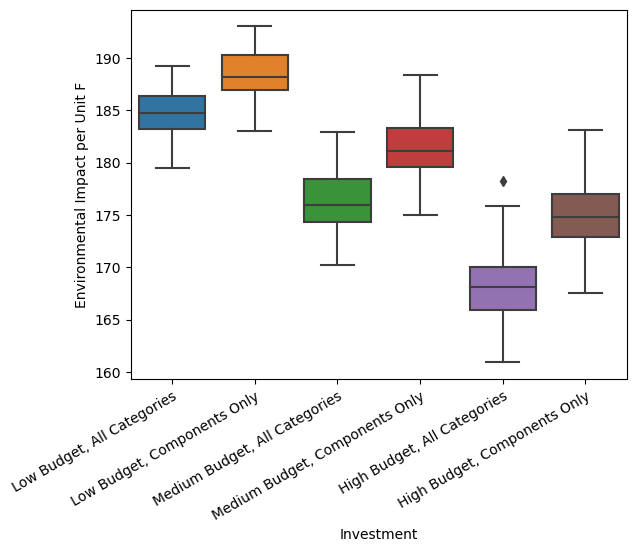

In [15]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "Environment",
        level="Index"
    ).groupby(["Investment", "Sample"]).sum(numeric_only=True).reset_index()[["Investment", "Value"]],
    order=[
        "Low Budget, All Categories"      ,
        "Low Budget, Components Only"  ,
        "Medium Budget, All Categories"      ,
        "Medium Budget, Components Only"    ,
        "High Budget, All Categories",
        "High Budget, Components Only"
    ]
)
g.set(ylabel="Environmental Impact per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor');

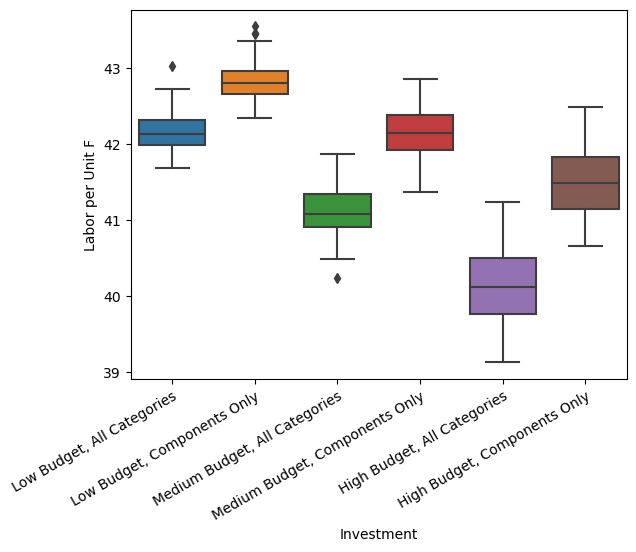

In [16]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "Labor",
        level="Index"
    ).groupby(["Investment", "Sample"]).sum(numeric_only=True).reset_index()[["Investment", "Value"]],
    order=[
        "Low Budget, All Categories"      ,
        "Low Budget, Components Only"  ,
        "Medium Budget, All Categories"      ,
        "Medium Budget, Components Only"    ,
        "High Budget, All Categories",
        "High Budget, Components Only"
    ]
)
g.set(ylabel="Labor per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor');

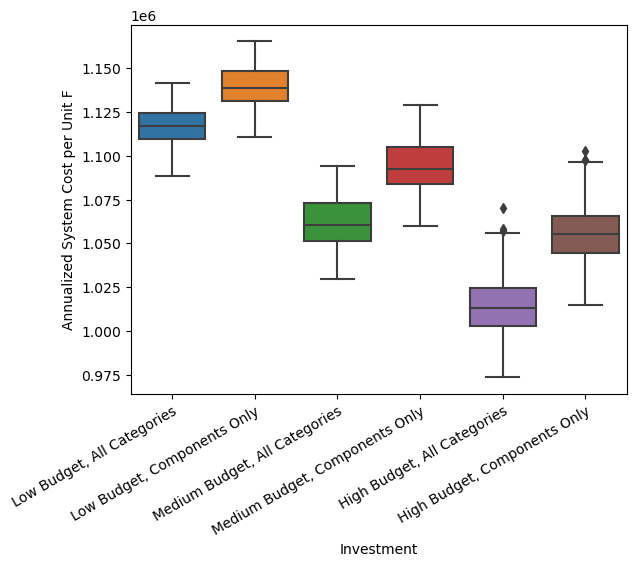

In [17]:
g = sb.boxplot(
    x="Investment",
    y="Value",
    data=investment_results.metrics.xs(
        "System Cost",
        level="Index"
    ).groupby(["Investment", "Sample"]).sum(numeric_only=True).reset_index()[["Investment", "Value"]],
    order=[
        "Low Budget, All Categories"      ,
        "Low Budget, Components Only"  ,
        "Medium Budget, All Categories"      ,
        "Medium Budget, Components Only"    ,
        "High Budget, All Categories",
        "High Budget, Components Only"
    ]
)
g.set(ylabel="Annualized System Cost per Unit F")
g.set_xticklabels(g.get_xticklabels(), rotation=30, ha='right', rotation_mode='anchor');

## Multi-objective decision analysis.

### Compute costs and metrics for tranches.

Tranches are atomic units for building investment portfolios. Evaluate all of the tranches, so we can assemble them into investments (portfolios).

In [18]:
tranche_results = investments.evaluate_tranches(designs, sample_count=50)

Evaluating Technology A
Evaluating Technology M


Display the cost of each tranche.

In [19]:
tranche_results.amounts

Amount
Category                 Tranche                               
Research on Component B  Component B No Funding             0.0
Research on Component B0 Component B0 High Funding    3500000.0
                         Component B0 Low Funding     1500000.0
                         Component B0 Medium Funding  1800000.0
Research on Component B1 Component B1 High Funding    3000000.0
                         Component B1 Low Funding     1250000.0
                         Component B1 Medium Funding  1000000.0
Research on Component B2 Component B2 High Funding    2500000.0
                         Component B2 Low Funding     1000000.0
                         Component B2 Medium Funding  1200000.0
Research on Component C  Component C High Funding     3000000.0
                         Component C Low Funding      1000000.0
                         Component C Medium Funding   2000000.0
                         Component C No Funding             0.0
Research on Component N  Component N High Funding     3500000.0
                         Component N Low Funding      1750000.0
                         Component N Medium Funding   2500000.0
                         Component N No Funding             0.0
Research on Efficiency   Efficiency High Funding      2500000.0
                         Efficiency Low Funding       1500000.0
                         Efficiency Medium Funding    2000000.0
                         Efficiency No Funding              0.0
Research on Peripherals  Peripherals High Funding     2250000.0
                         Peripherals Low Funding      1250000.0
                         Peripherals Medium Funding   1750000.0
                         Peripherals No Funding             0.0

Display the metrics for each tranche.

In [20]:
tranche_results.summary

Value  \
Category                Technology   Tranche                Sample Index                               
Research on Component B Technology A Component B No Funding 1      Environment             21.797460   
                                                                   Labor                    3.295484   
                                                                   Overall Efficiency       0.298617   
                                                                   System Cost         109622.347873   
                                                            2      Environment             21.915342   
...                                                                                              ...   
Research on Peripherals Technology M Peripherals No Funding 49     System Cost          66448.153707   
                                                            50     Environment              7.336233   
                                                                   Labor                    2.933804   
                                                                   Overall Efficiency       0.417723   
                                                                   System Cost          66609.663322   

                                                                                                              Units  
Category                Technology   Tranche                Sample Index                                             
Research on Component B Technology A Component B No Funding 1      Environment                    delta unit/system  
                                                                   Labor                           delta USD/system  
                                                                   Overall Efficiency                      unitless  
                                                                   System Cost         delta USD/system, annualized  
                                                            2      Environment                    delta unit/system  
...                                                                                                             ...  
Research on Peripherals Technology M Peripherals No Funding 49     System Cost         delta USD/system, annualized  
                                                            50     Environment                    delta unit/system  
                                                                   Labor                           delta USD/system  
                                                                   Overall Efficiency                      unitless  
                                                                   System Cost         delta USD/system, annualized  

[10400 rows x 2 columns]

Save the results.

In [21]:
#tranche_results.amounts.to_csv("example-tranche-amounts.csv")
#tranche_results.summary.to_csv("example-tranche-summary.csv")

### Fit a response surface to the results.

The response surface interpolates between the discrete set of cases provided in the expert elicitation. This allows us to study funding levels intermediate between those scenarios.

In [22]:
evaluator = ty.Evaluator(tranche_results)

Here are the categories of investment and the maximum amount that could be invested in each:

In [23]:
evaluator.max_amount

,Amount
Category,
Research on Component B,0.0
Research on Component B0,3500000.0
Research on Component B1,3000000.0
Research on Component B2,2500000.0
Research on Component C,3000000.0
Research on Component N,3500000.0
Research on Efficiency,2500000.0
Research on Peripherals,2250000.0


Here are the metrics and their units of measure:

In [24]:
evaluator.units

,Units
Index,
Environment,delta unit/system
Labor,delta USD/system
Overall Efficiency,unitless
System Cost,"delta USD/system, annualized"


#### Example interpolation.

Let's evaluate the case where each category is invested in at half of its maximum amount.

In [25]:
example_investments = evaluator.max_amount / 2
example_investments

,Amount
Category,
Research on Component B,0.0
Research on Component B0,1750000.0
Research on Component B1,1500000.0
Research on Component B2,1250000.0
Research on Component C,1500000.0
Research on Component N,1750000.0
Research on Efficiency,1250000.0
Research on Peripherals,1125000.0


In [26]:
evaluator.evaluate(example_investments)

C:\Users\rhanes\AppData\Local\Continuum\anaconda3\envs\tyche-1.2\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\rhanes\AppData\Local\Continuum\anaconda3\envs\tyche-1.2\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


Category                 Index        Sample
Research on Component B  Environment  1                        nan
                                      2                        nan
                                      3                        nan
                                      4                        nan
                                      5                        nan
                                                       ...        
Research on Peripherals  System Cost  46        104440.62484369054
                                      47        105985.98551932158
                                      48          106705.834784794
                                      49        104813.78665628278
                                      50         106224.3226083845
Name: Value, Length: 1600, dtype: object

Let's evaluate the mean instead of outputing the whole distribution.

In [27]:
evaluator.evaluate_statistic(example_investments, np.mean)

C:\Users\rhanes\AppData\Local\Continuum\anaconda3\envs\tyche-1.2\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\rhanes\AppData\Local\Continuum\anaconda3\envs\tyche-1.2\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


,Value
Index,
Environment,NaN
Labor,NaN
Overall Efficiency,NaN
System Cost,NaN


Here is the standard deviation:

In [28]:
evaluator.evaluate_statistic(example_investments, np.std)

C:\Users\rhanes\AppData\Local\Continuum\anaconda3\envs\tyche-1.2\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\rhanes\AppData\Local\Continuum\anaconda3\envs\tyche-1.2\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


,Value
Index,
Environment,NaN
Labor,NaN
Overall Efficiency,NaN
System Cost,NaN


A risk-averse decision maker might be interested in the 10% percentile:

In [29]:
evaluator.evaluate_statistic(example_investments, lambda x: np.quantile(x, 0.1))

C:\Users\rhanes\AppData\Local\Continuum\anaconda3\envs\tyche-1.2\lib\site-packages\scipy\interpolate\_interpolate.py:653: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\rhanes\AppData\Local\Continuum\anaconda3\envs\tyche-1.2\lib\site-packages\scipy\interpolate\_interpolate.py:656: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


,Value
Index,
Environment,NaN
Labor,NaN
Overall Efficiency,NaN
System Cost,NaN


### ε-Constraint multiobjective optimization

In [30]:
optimizer = ty.EpsilonConstraintOptimizer(evaluator)

In order to meaningfully map the decision space, we need to know the maximum values for each of the metrics.

#### Example optimization.

Limit spending to $3M.

In [31]:
investment_max = 3e6

Require that the GHG reduction be at least 40 gCO2e/system and that the Labor wages not decrease.

In [32]:
metric_min = pd.Series([40, 0], name = "Value", index = ["GHG", "Labor"])
metric_min

GHG      40
Labor     0
Name: Value, dtype: int64

Compute the ε-constrained maximum for the LCOE.

In [33]:
optimum = optimizer.opt_slsqp(
    "LCOE"                       ,
    sense = 'max',
    total_amount = investment_max,
    statistic    = np.mean       ,
)
optimum.exit_message

ValueError: x and y arrays must have at least 2 entries

Here are the optimal spending levels:

In [ ]:
np.round(optimum.amounts)

Here are the three metrics at that optimum:

In [ ]:
optimum.metrics

*Thus, by putting all of the investment into Module R&D, we can expected to achieve a mean 3.75 ¢/kWh reduction in LCOE under the GHG and Labor constraints.*

It turns out that there is no solution for these constraints if we evaluate the 10th percentile of the metrics, for a risk-averse decision maker.

In [ ]:
optimum = optimizer.opt_slsqp(
    "LCOE"                       ,
    sense = 'max',
    total_amount = investment_max,
    statistic    = lambda x: np.quantile(x, 0.1),
)
optimum.exit_message

Let's try again, but with a less stringent set of constraints, only constraining GHG somewhat  but not Labor at all.

In [ ]:
optimum = optimizer.opt_slsqp(
    "LCOE"                                                         ,
    sense = 'max',
    total_amount = investment_max                                  ,
    statistic    = lambda x: np.quantile(x, 0.1)                  ,
)
optimum.exit_message

In [ ]:
np.round(optimum.amounts)

In [ ]:
optimum.metrics

## Reproducing GUI optimization for Git issue 99
See: https://github.com/NREL/tyche/issues/99

### Example MILP optimization

This formulation converts the original non-linear optimization into a piecewise linear, mixed-integer optimization, and then attempts to solve the same problem.

~~As written, the MILP formulation is infeasible.~~

In [ ]:
investment_max = 3e6
metric_min = pd.Series([40, 0], name = "Value", index = ["GHG", "Labor"])

optimum = optimizer.opt_milp(
    "LCOE"                       ,
    sense = 'max',
    total_amount = investment_max,
    statistic    = np.mean       ,
)

optimum.exit_message

Let's determine if the problem is truly infeasible or if the solver is failing by examining the underlying data.

In [ ]:
_wide = evaluator.evaluate_corners_wide(np.mean).reset_index()
_wide

Add a column to the above data with the total investment amount.

In [ ]:
_wide['total R&D'] = _wide.loc[:,'BoS R&D'] + _wide.loc[:, 'Inverter R&D'] + _wide.loc[:, 'Module R&D']
_wide

Look for entries that meet the total investment constraint of less than $3 MM.

In [ ]:
_wide.loc[_wide['total R&D'] <= 3e6,:]

~~This entry does not meet the GHG constraint, which is why the MILP formulation is infeasible.~~